### Day 017 : Hyperparameter Tuning (Improve the Best Model) and MODEL INTERPRETATION & FINALIZATION
***Today’s Goal:*** Optimize the Gradient Boosting model using hyperparameter tuning to improve prediction performance.
- Interpret the best model using feature importance, analyze prediction errors, and save the final trained model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('clean_netflix_data.csv')
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,6.6,2279.0,0.600,6.9
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,"['crime', 'drama']",['US'],0.0,8.3,795222.0,27.612,8.2
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['comedy', 'fantasy']",['GB'],0.0,8.2,530877.0,18.216,7.8
3,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,['comedy'],['GB'],0.0,8.0,392419.0,17.505,7.8
4,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,['horror'],['US'],0.0,8.1,391942.0,95.337,7.7


#### data processing

In [3]:
# Select Final Features
y = df['imdb_score']
X = df.drop([
    'imdb_score',
    'id',
    'title',
    'description',
], axis=1)

# Convert ALL categorical columns at once
X = pd.get_dummies(X, drop_first=True)

# Remove Boolean Type
bool_cols = X.select_dtypes(include='bool').columns
X[bool_cols] = X[bool_cols].astype(int)

# Train Test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#### Import GridSearch

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

#### Define Parameter Grid

In [5]:
param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8]
}


#### Run Grid Search

In [9]:
gb = GradientBoostingRegressor(random_state=42)

grid = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs = -1
)

In [10]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [100], 'subsample': [0.8]},
             scoring='r2')

#### Best Parameters

In [11]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [13]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error

print("Tuned R2:", r2_score(y_test, y_pred_best))
print("Tuned RMSE:", mean_squared_error(y_test, y_pred_best))


Tuned R2: 0.5022350278672816
Tuned RMSE: 0.5413478983388513


### Feature Importance (From Best Model)

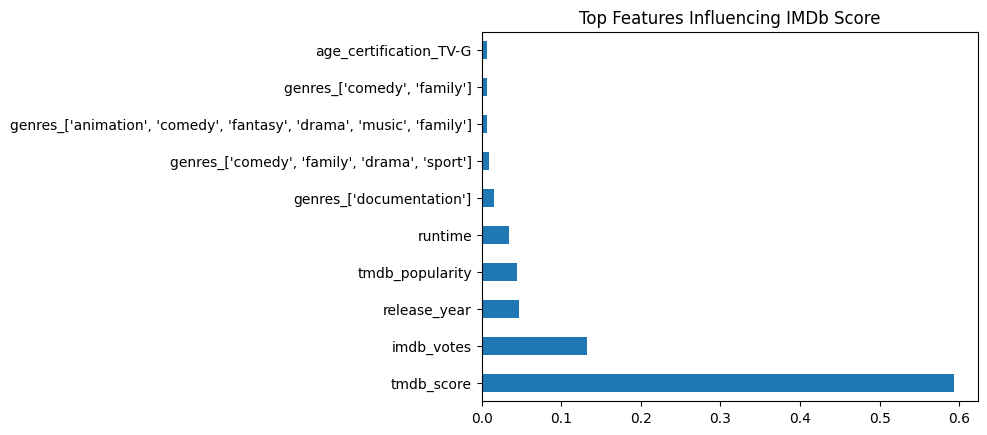

In [14]:
importance = pd.Series(best_model.feature_importances_, index=X.columns)
top_features = importance.sort_values(ascending=False).head(10)

top_features.plot(kind='barh')
plt.title("Top Features Influencing IMDb Score")
plt.show()


### Residual Analysis (Model Error Check)

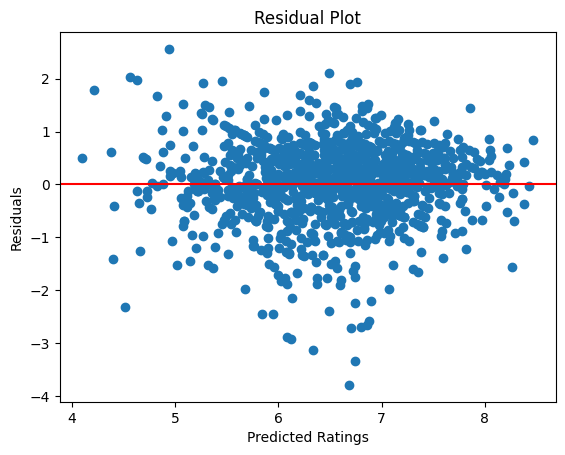

In [15]:
residuals = y_test - y_pred_best

plt.scatter(y_pred_best, residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


- If points are randomly spread → model is good
- If pattern exists → model missing something

### Save the Model

In [18]:
import joblib

joblib.dump(best_model, "imdb_rating_predictor.pkl")


['imdb_rating_predictor.pkl']

### Final Model Evaluation Summary

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Final Tuned Model R2:", r2_score(y_test, y_pred_best))
print("Final RMSE:", mean_squared_error(y_test, y_pred_best))
print("Final MAE:", mean_absolute_error(y_test, y_pred_best))


Final Tuned Model R2: 0.5022350278672816
Final RMSE: 0.5413478983388513
Final MAE: 0.5410560019135051


Data → Cleaning → EDA → Features → Models → Tuning → Interpretation → Final Model

#### Learnings:
- Feature importance helps identify which input variables contribute most to model predictions
- Residual analysis is used to examine the difference between actual and predicted values
- A random residual pattern indicates a well-fitted model, while patterns suggest missing relationships
- Model evaluation should include both performance metrics and error distribution analysis
- Saving the trained model (e.g., using joblib/pickle) allows reuse without retraining
- Final model validation ensures the model generalizes well before deployment